This file is meant to tune the hyperparameters of the Linear and RNN models. 500 random combinations are trained for 100 epochs with early stopping using MSE as a loss function. The combination that produces the lowest validation loss is then chosen and those parameters saved to be used in the final model training. A brief experiment on the impact of stacking GRU layers on model performance is also included.<br>

Last updated: 4/15/2025

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from json import dump
# PyTorch imports
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
# Local import
from tools import train_model, evaluate_model, best_hyperparameter_results, visualize_all_hyperparameter_results, EarlyStopping, get_dataloaders
from models import SimpleNet, BaseballRNN

In [3]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Using:", DEVICE)

Using: cuda


In [4]:
#pip freeze > requirements.txt

# Load Data and Create Dataset

Dataset and dataloaders are used for both models.

In [5]:
# Load saved tensor for inputs and targest
input_values = torch.load('./datasets/input_values.pth')
target_values = torch.load('./datasets/target_values.pth')

# Create Dataset
dataset = TensorDataset(input_values, target_values)

# Split and scale original dataset
train_dataset, valid_dataset, test_dataset = get_dataloaders(dataset)

# Create consistent test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

Train: 80.1%, Test: 10.0%, Valid: 9.9%
Train inputs shape: torch.Size([57640, 9, 15]). Mean, Std: [0.0,1.0]
Valid inputs shape: torch.Size([7123, 9, 15]). Mean, Std: [0.0,1.0]
Test inputs shape: torch.Size([7195, 9, 15]). Mean, Std: [-0.0,1.0]


# Simple Linear model

### MLP hyperparameter tuning

In [6]:
# Number of random combinations to sample
num_random_combinations = 500  

# Define hyperparameters to test
testing_params = {
    'batch_size': [16, 32, 64, 128, 256],
    'lr': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    'mlp_dropout': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'weight_decay': [0.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
    'hidden_size': [8, 16, 64, 128, 256],
    'grad_clip': [None, 0.5, 1.0, 2.0, 5.0]
}

# Generate random combinations
random_param_combinations = [
    (
        random.choice(testing_params['batch_size']),
        random.choice(testing_params['lr']),
        random.choice(testing_params['mlp_dropout']),
        random.choice(testing_params['weight_decay']),
        random.choice(testing_params['hidden_size']),
        random.choice(testing_params['grad_clip'])
    )
    for _ in range(num_random_combinations)
]

# Save what parameters are being tested
mlp_hyperparam_testing = pd.DataFrame(random_param_combinations, columns=testing_params.keys())

In [7]:
results = {}
num_epochs = 100
early_stop_patience = 15
loss = 'MSE'

# Initialize tqdm progress bar to track progress through iterations
pbar = tqdm(random_param_combinations, desc="Training Models", total=len(random_param_combinations))

# Iterate over parameter combinations
for i, (batch_size, lr, mlp_dropout, weight_decay, hidden_size, grad_clip) in enumerate(pbar):

    # Turn dataset into Dataloaders
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

    # Create model
    input_size, seq_len = valid_dataloader.dataset[0][0].shape
    simple_baseball_mlp = SimpleNet(input_size=input_size, seq_len=seq_len, hidden_features=hidden_size, dropout=mlp_dropout).to(DEVICE)

    # Optimizer and early stopper
    optimizer = Adam(simple_baseball_mlp.parameters(), lr=lr, weight_decay=weight_decay)
    early_stopper = EarlyStopping(patience=early_stop_patience, min_delta=0.0001)

    # Training
    eval_log = []

    # Training loop
    for epoch in range(num_epochs):
        # Validation loss
        avg_valid_loss = train_model(simple_baseball_mlp, optimizer, valid_dataloader, DEVICE, loss_fn=loss, grad_clip=grad_clip)
        eval_log.append(avg_valid_loss)
    
        # Early Stopping
        early_stopper(avg_valid_loss)
        if early_stopper.early_stop:
            #print(f"Early stopping at epoch {epoch}")
            break    
    
    # Save results
    results[i] = [eval_log]

    # Final evaluation
    valid_accuracy = evaluate_model(model=simple_baseball_mlp, dataloader=test_dataloader, device=DEVICE, loss_fn=loss)
    # Save results
    results[i].append(valid_accuracy)
    results[i].append(f'Batch size: {batch_size}, lr: {lr}, dropout: {mlp_dropout}\n l2: {weight_decay}, hidden_size: {hidden_size}, grad_clip: {grad_clip}\n{loss}: {valid_accuracy:.4}')
    # Append training epochs
    results[i].append(epoch+1)


Training Models: 100%|██████████| 500/500 [3:22:19<00:00, 24.28s/it]  


Evaluate the models, first by lowest RSME. Also visualize results to make sure that they aren't overfitting.

6 best models (index and values):
(338, 0.13732866345800568)
(325, 0.13743040304245263)
(120, 0.13758603858400997)
(329, 0.13761708288452873)
(256, 0.1376449868683603)
(304, 0.1376676914590858)


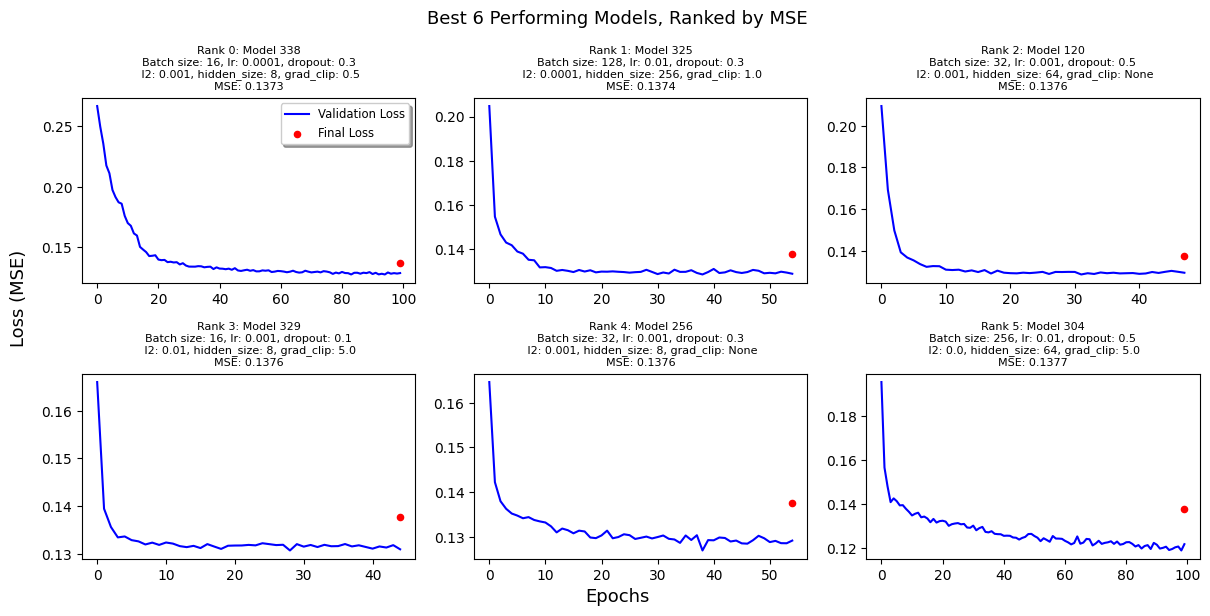

In [8]:
best_hyperparameter_results(results, loss=loss, n_best=6)

In [9]:
# Save full results to csv
mlp_hyperparam_testing['result_variance'] = [np.var(results[i][0]) for i in results]
mlp_hyperparam_testing['tuning_epochs'] = [results[i][3] for i in results]
mlp_hyperparam_testing[f'tuning_loss_{loss}'] = [results[i][1] for i in results]
mlp_hyperparam_testing.to_csv('./tuning/mlp_hyperparameter_tuning.csv')

In [10]:
# Determine best hyperparameters based on loss
min_index = mlp_hyperparam_testing['tuning_loss_MSE'].idxmin()
best_mlp_params = mlp_hyperparam_testing.iloc[min_index].to_dict()
print("Best MLP Parameters:")
for key in best_mlp_params:
    print(f"{key}: {best_mlp_params[key]}")

# Write these results to file
with open('./tuning/mlp_best_params.json', 'w') as file:
    best_mlp_params.pop('tuning_loss_MSE', None)
    best_mlp_params.pop('result_variance', None)
    best_mlp_params.pop('tuning_epochs', None)

    dump(best_mlp_params, file, indent=4)

Best MLP Parameters:
batch_size: 16.0
lr: 0.0001
mlp_dropout: 0.3
weight_decay: 0.001
hidden_size: 8.0
grad_clip: 0.5
result_variance: 0.000687711447640743
tuning_epochs: 100.0
tuning_loss_MSE: 0.13732866345800568


# RNN Network

A many-to-one RNN using gated recurrence units (GRUs)

In [11]:
# Number of random combinations to sample
num_random_combinations = 500  

# Define hyperparameters to test
testing_params = {
    'batch_size': [16, 32, 64, 128, 256],
    'n_layers': [1, 2, 3, 5],
    'lr': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    'rnn_dropout': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'weight_decay': [0.0, 1e-2, 1e-3, 1e-4, 1e-5],
    'grad_clip': [None, 0.5, 1.0, 2.0, 5.0],
    'hidden_size': [8, 16, 64, 128, 256],
}

# Generate random combinations
random_param_combinations = [
    (
        random.choice(testing_params['batch_size']),
        random.choice(testing_params['n_layers']),
        random.choice(testing_params['lr']),
        random.choice(testing_params['rnn_dropout']),
        random.choice(testing_params['weight_decay']),
        random.choice(testing_params['grad_clip']),
        random.choice(testing_params['hidden_size'])
    )
    for _ in range(num_random_combinations)
]

# Save what parameters are being tested
rnn_hyperparam_testing = pd.DataFrame(random_param_combinations, columns=testing_params.keys())

In [12]:
results_rnn = {}
num_epochs = 100
early_stop_patience = 15
loss = 'MSE'

# Initialize tqdm progress bar to track progress through 144 iterations
pbar = tqdm(random_param_combinations, desc="Training Models", total=len(random_param_combinations))

# Iterate over parameter combinations
for i, (batch_size, n_layers, lr, rnn_dropout, weight_decay, grad_clip, hidden_size) in enumerate(pbar):

    # Turn into Dataloaders
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    # Create model
    input_size = valid_dataloader.dataset[0][0].size()[1]
    baseball_rnn = BaseballRNN(input_size=input_size, hidden_size=hidden_size, n_layers=n_layers,
                                hidden_init='rand', rnn_dropout=rnn_dropout).to(DEVICE)

    # Optimizer and early stopping
    optimizer = Adam(baseball_rnn.parameters(), lr=lr, weight_decay=weight_decay)
    early_stopper = EarlyStopping(patience=early_stop_patience, min_delta=0.0001)

    # Training
    eval_log_rnn = []
    for epoch in range(num_epochs):
        
        # Validation loss
        avg_valid_loss = train_model(baseball_rnn, optimizer, valid_dataloader, DEVICE, loss_fn=loss, grad_clip=grad_clip)
        eval_log_rnn.append(avg_valid_loss)
        # Early Stopping
        early_stopper(avg_valid_loss)
        if early_stopper.early_stop:
            #print(f"Early stopping at epoch {epoch}")
            break    

    # Save results
    results_rnn[i] = [eval_log_rnn] 

    # Test evaluation
    test_accuracy_rnn = evaluate_model(model=baseball_rnn, dataloader=test_dataloader, device=DEVICE, loss_fn=loss)
    # Save results
    results_rnn[i].append(test_accuracy_rnn)
    results_rnn[i].append(f'Batch size:{batch_size}, lr:{lr}, n_layers:{n_layers}, dropout:{mlp_dropout}\n l2:{weight_decay}, hidden_size:{hidden_size}, grad_clip:{grad_clip}\n{loss}: {test_accuracy_rnn:.4}')

    # Append training epochs
    results_rnn[i].append(epoch+1)


Training Models:   1%|          | 5/500 [03:26<5:55:48, 43.13s/it]c:\Users\Zachary\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
Training Models:   2%|▏         | 8/500 [04:04<2:46:54, 20.36s/it]c:\Users\Zachary\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
Training Models:   2%|▏         | 12/500 [08:30<8:50:42, 65.25s/it]c:\Users\Zachary\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers g

6 best models (index and values):
(457, 0.1368727467327668)
(125, 0.13692204261132626)
(83, 0.13694987707331913)
(278, 0.13713097438537222)
(376, 0.1373552094842097)
(446, 0.1374721094075386)


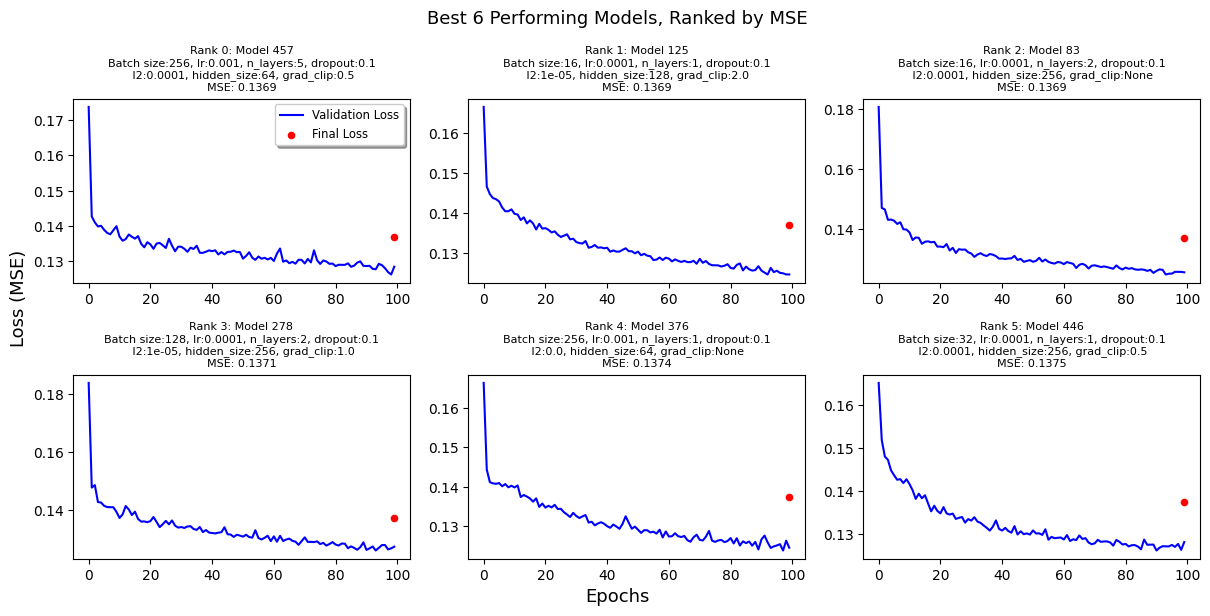

In [13]:
best_hyperparameter_results(results_rnn, loss=loss, n_best=6)

In [14]:
# Save full results to csv
mlp_hyperparam_testing['result_variance'] = [np.var(results_rnn[i][0]) for i in results_rnn]
rnn_hyperparam_testing['tuning_epochs'] = [results_rnn[i][3] for i in results_rnn]
rnn_hyperparam_testing[f'tuning_loss_{loss}'] = [results_rnn[i][1] for i in results_rnn]
rnn_hyperparam_testing.to_csv('./tuning/rnn_hyperparameter_tuning.csv')

In [15]:
# Determine best hyperparameters based on loss
min_index = rnn_hyperparam_testing['tuning_loss_MSE'].idxmin()
best_rnn_params = rnn_hyperparam_testing.iloc[min_index].to_dict()
print("Best RNN Parameters:")
for key in best_rnn_params:
    print(f"{key}: {best_rnn_params[key]}")

# Write these results to file
with open('./tuning/rnn_best_params.json', 'w') as file:
    best_rnn_params.pop('tuning_loss_MSE', None)
    best_rnn_params.pop('result_variance', None)
    best_rnn_params.pop('tuning_epochs', None)

    dump(best_rnn_params, file, indent=4)

Best RNN Parameters:
batch_size: 256.0
n_layers: 5.0
lr: 0.001
rnn_dropout: 0.3
weight_decay: 0.0001
grad_clip: 0.5
hidden_size: 64.0
tuning_epochs: 100.0
tuning_loss_MSE: 0.1368727467327668


## RNN Layer Experiment

Showing effect of the number of RNN layers on final model performance.

In [16]:
# Initialize the model and move it to the appropriate device
layers = [1, 2, 5, 10, 20, 50]
layer_losses = {layer: [] for layer in layers}

num_epochs = 30

# Get best hyperparameters from tuning
lr = best_rnn_params['lr']
grad_clip = best_rnn_params['grad_clip']
#batch_size = best_rnn_params_layer['batch_size']
weight_decay = best_rnn_params['weight_decay']
hidden_size = int(best_rnn_params['hidden_size'])
rnn_dropout = best_rnn_params['rnn_dropout']

# Run experiment
for rnn_layer in layers:

    # Initialize model
    input_size = test_dataloader.dataset[0][0].size()[1]
    RNN_model = BaseballRNN(input_size=input_size, rnn_dropout=rnn_dropout, hidden_size=hidden_size, n_layers=rnn_layer).to(DEVICE)

    # Define the loss function and optimizer
    optimizer = torch.optim.Adam(RNN_model.parameters(), lr=lr, weight_decay=weight_decay)

    # Training loop
    pbar = tqdm(range(num_epochs), desc=f"Training RNN ({rnn_layer} layers)")
    for epoch in pbar:

        # Get average loss over batches for training
        avg_train_loss = train_model(RNN_model, optimizer, test_dataloader, DEVICE, loss_fn='RMSE', grad_clip=grad_clip)
        avg_valid_loss = evaluate_model(RNN_model, valid_dataloader, DEVICE, loss_fn='RMSE')

        layer_losses[rnn_layer].append(avg_train_loss)
        #dropout_losses[rnn_dropout][1].append(avg_train_loss)

        pbar.set_postfix({'Train loss': avg_train_loss, 'Validation loss': avg_valid_loss})

c:\Users\Zachary\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
Training RNN (50 layers): 100%|██████████| 30/30 [01:02<00:00,  2.10s/it, Train loss=0.381, Validation loss=0.372]


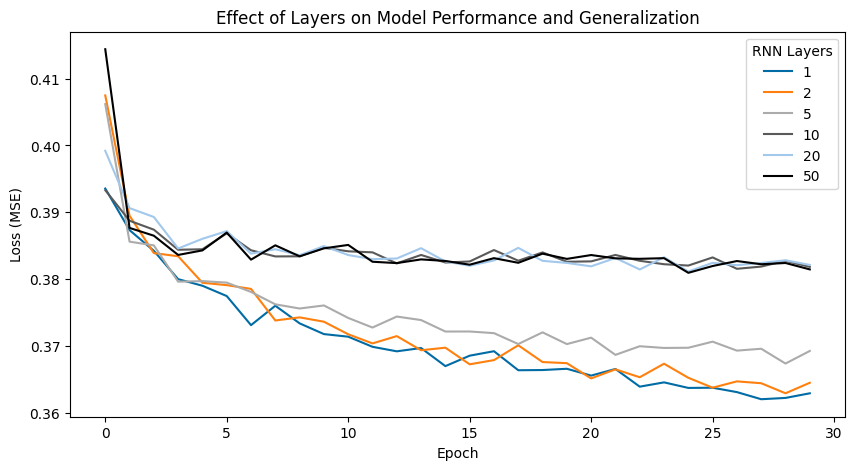

In [17]:
# Plot loss over time
plt.figure(figsize=(10, 5))
plt.title(f'Effect of Layers on Model Performance and Generalization', fontsize=12)
#plt.title(f'(Solid: Training Loss. Dashed: Validation Loss)', fontsize=10)
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
colors = ['r', 'g', 'b', 'y', 'c', 'black']
colors = ['#006BA4', '#FF800E', '#ABABAB', '#595959', '#A2C8EC', "#000000"]
for i, layer in enumerate(layer_losses):
    #plt.plot(dropout_losses[dp][0], label=dp, linestyle='solid')
    plt.plot(layer_losses[layer], linestyle='solid', c=colors[i], label=layer)
#plt.plot(np.array([layer_losses[dl][1] for dl in layer_losses]).mean(axis=0), color='black')
plt.legend(title='RNN Layers', loc='upper right')

plt.show()